UnetGenerator(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.1015625, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): Identity()
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.1015625, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): Identity()
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.1015625, inplace=True)
                  (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                  (2): Identity()
                  (3): U

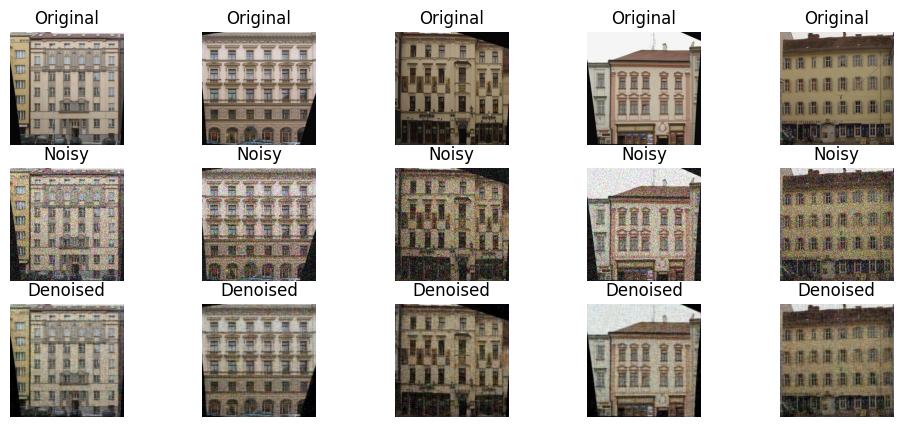

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch
from models_cle_mod_novai import *

BATCH_SIZE = 64
EPOCHS = 600
NOISE_FACTOR = 0.2
LEARNING_RATE = 0.001

criterion = nn.MSELoss()
dataset_path = 'facades'



def add_noise(images, noise_factor=NOISE_FACTOR):
    noise = noise_factor * torch.randn_like(images)
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0., 1.)  # Ensure values stay within [0, 1]
    return noisy_images

def test(model, testloader, device):
    model.eval()
    model.to(device)
    test_loss = 0
    with torch.no_grad():
        for images in testloader:
            images = images.to(device)
            noisy_images = add_noise(images).to(device)
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            test_loss += loss.item()
    return test_loss / len(testloader)

def train(model, trainloader, device):
    model.train()
    model.to(device)
    train_loss = 0
    for images in trainloader:
        images = images.to(device)
        noisy_images = add_noise(images).to(device)
        
        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(trainloader)



class FacadesDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        self.image_dir = os.path.join(root_dir, f'{mode}A')  # trainA or testA
        self.image_files = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')  # RGB

        if self.transform:
            image = self.transform(image)

        return image 



# set up dataset and dataloaders
transform = transforms.Compose([
    transforms.Resize((256, 256)),      
    transforms.ToTensor(),               
])
train_dataset = FacadesDataset(root_dir=dataset_path, transform=transform, mode='train')
test_dataset = FacadesDataset(root_dir=dataset_path, transform=transform, mode='test')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# create model
model = UnetGenerator(input_nc=3, output_nc=3, num_downs=8)
print(model)
# set training parameters
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# training loop
for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader, device)
    test_loss = test(model, test_loader, device)
    psnr_loss = 10 * np.log10(1 / test_loss)  # PSNR calculation
    print(f'Epoch [{epoch}/{EPOCHS}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, PSNR: {psnr_loss:.4f} dB')
# check results
# model back to CPU for visualization
model = model.to('cpu')

# Assuming dataiter, testloader, add_noise, and model are defined
dataiter = iter(test_loader)
images = next(dataiter)
noisy_images = add_noise(images)
outputs = model(noisy_images)


number_of_images = 5  # Number of images to visualize

# Plot original, noisy, and denoised images
fig, axes = plt.subplots(3, number_of_images, figsize=(12, number_of_images))
for i in range(number_of_images):
    # Transpose images from (3, 32, 32) to (32, 32, 3) for RGB
    # Original images
    orig_img = images[i].permute(1, 2, 0).numpy()  # Change shape to (32, 32, 3)
    # map the values to [0, 1] range for visualization
    orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min())
    # print the shape and type and value range of the original image
    #print(f"Original image shape: {orig_img.shape}, type: {orig_img.dtype}, value range: {orig_img.min()} - {orig_img.max()}")
    axes[0, i].imshow(orig_img)
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    # save the original image to clean folder
    
    # Noisy images
    noisy_img = noisy_images[i].permute(1, 2, 0).numpy()  # Change shape to (32, 32, 3)
    # map the values to [0, 1] range for visualization
    noisy_img = (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())
    # print the shape and type of the noisy image
    #print(f"Noisy image shape: {noisy_img.shape}, type: {noisy_img.dtype}, value range: {noisy_img.min()} - {noisy_img.max()}")
    #noisy_img = (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())  # Normalize for visualization
    axes[1, i].imshow(noisy_img)
    axes[1, i].set_title("Noisy")
    axes[1, i].axis('off')
    
    # Denoised images
    denoised_img = outputs[i].permute(1, 2, 0).detach().numpy()  # Change shape to (32, 32, 3)
    # map the values to [0, 1] range for visualization
    denoised_img = (denoised_img - denoised_img.min()) / (denoised_img.max() - denoised_img.min())
    # print the shape and type of the denoised image
    #print(f"Denoised image shape: {denoised_img.shape}, type: {denoised_img.dtype}, value range: {denoised_img.min()} - {denoised_img.max()}")
    axes[2, i].imshow(denoised_img)
    axes[2, i].set_title("Denoised")
    axes[2, i].axis('off')

    # save all images to their corresponding folders under 3_output
    # if folder does not exist, create it
    import os
    output_dir = 'build/facades_test_cle_mod'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    clean_dir = os.path.join(output_dir, 'clean')
    noisy_dir = os.path.join(output_dir, 'noisy')
    denoised_dir = os.path.join(output_dir, 'should_denoised')
    if not os.path.exists(clean_dir):
        os.makedirs(clean_dir)
    if not os.path.exists(noisy_dir):
        os.makedirs(noisy_dir)
    if not os.path.exists(denoised_dir):
        os.makedirs(denoised_dir)
    # save images
    from torchvision.utils import save_image
    save_image(images[i], os.path.join(clean_dir, f'clean_{i}.png'))
    save_image(noisy_images[i], os.path.join(noisy_dir, f'noisy_{i}.png'))
    save_image(outputs[i], os.path.join(denoised_dir, f'denoised_{i}.png')) 
print(f"Images saved to {output_dir}")
# save the float model pth and onnx
model_name = 'cle_mod_vai_unet'
# check path exists
if not os.path.exists('build/float_model'):
    os.makedirs('build/float_model')
# save the model state dict
torch.save(model.state_dict(), 'build/float_model/'+ model_name + '_'+ 'facades'  +'_f32.pth', _use_new_zipfile_serialization=False )
dummy_input = torch.randn(1, 3, 256, 256, dtype=torch.float32)
torch.onnx.export(model, dummy_input, 'build/float_model/'+ model_name + '_'+ 'facades' +'_f32.onnx', 
                input_names=['input'], output_names=['output'], 
                dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})
print(f"Model saved to build/float_model/{model_name}_facades_f32.pth and .onnx")

UnetGenerator(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): Identity()
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): Identity()
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                  (2): Identity()
                  (3): UnetSkipConnectionB

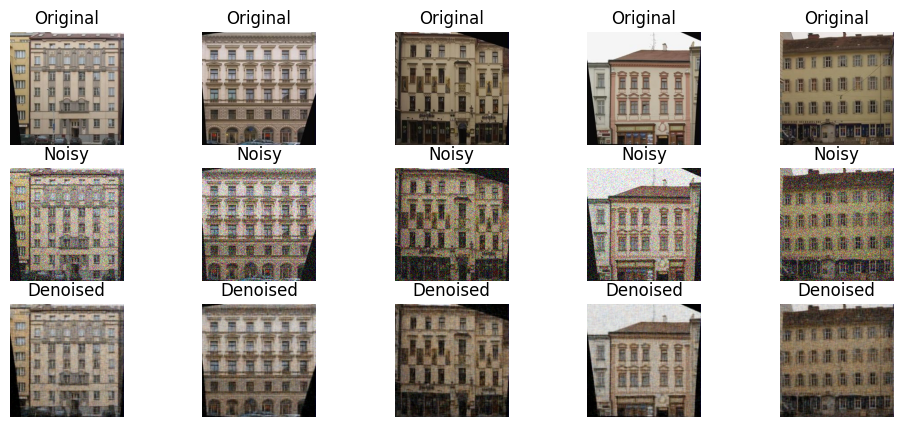

In [11]:
from models_cle import *

model = UnetGenerator(input_nc=3, output_nc=3, num_downs=8)
print(model)
# set training parameters
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# training loop
for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader, device)
    test_loss = test(model, test_loader, device)
    psnr_loss = 10 * np.log10(1 / test_loss)  # PSNR calculation
    print(f'Epoch [{epoch}/{EPOCHS}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, PSNR: {psnr_loss:.4f} dB')
# check results
# model back to CPU for visualization
model = model.to('cpu')

# Assuming dataiter, testloader, add_noise, and model are defined
dataiter = iter(test_loader)
images = next(dataiter)
noisy_images = add_noise(images)
outputs = model(noisy_images)


number_of_images = 5  # Number of images to visualize

# Plot original, noisy, and denoised images
fig, axes = plt.subplots(3, number_of_images, figsize=(12, number_of_images))
for i in range(number_of_images):
    # Transpose images from (3, 32, 32) to (32, 32, 3) for RGB
    # Original images
    orig_img = images[i].permute(1, 2, 0).numpy()  # Change shape to (32, 32, 3)
    # map the values to [0, 1] range for visualization
    orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min())
    # print the shape and type and value range of the original image
    #print(f"Original image shape: {orig_img.shape}, type: {orig_img.dtype}, value range: {orig_img.min()} - {orig_img.max()}")
    axes[0, i].imshow(orig_img)
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    # save the original image to clean folder
    
    # Noisy images
    noisy_img = noisy_images[i].permute(1, 2, 0).numpy()  # Change shape to (32, 32, 3)
    # map the values to [0, 1] range for visualization
    noisy_img = (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())
    # print the shape and type of the noisy image
    #print(f"Noisy image shape: {noisy_img.shape}, type: {noisy_img.dtype}, value range: {noisy_img.min()} - {noisy_img.max()}")
    #noisy_img = (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())  # Normalize for visualization
    axes[1, i].imshow(noisy_img)
    axes[1, i].set_title("Noisy")
    axes[1, i].axis('off')
    
    # Denoised images
    denoised_img = outputs[i].permute(1, 2, 0).detach().numpy()  # Change shape to (32, 32, 3)
    # map the values to [0, 1] range for visualization
    denoised_img = (denoised_img - denoised_img.min()) / (denoised_img.max() - denoised_img.min())
    # print the shape and type of the denoised image
    #print(f"Denoised image shape: {denoised_img.shape}, type: {denoised_img.dtype}, value range: {denoised_img.min()} - {denoised_img.max()}")
    axes[2, i].imshow(denoised_img)
    axes[2, i].set_title("Denoised")
    axes[2, i].axis('off')

    # save all images to their corresponding folders under 3_output
    # if folder does not exist, create it
    import os
    output_dir = 'build/facades_test_cle'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    clean_dir = os.path.join(output_dir, 'clean')
    noisy_dir = os.path.join(output_dir, 'noisy')
    denoised_dir = os.path.join(output_dir, 'should_denoised')
    if not os.path.exists(clean_dir):
        os.makedirs(clean_dir)
    if not os.path.exists(noisy_dir):
        os.makedirs(noisy_dir)
    if not os.path.exists(denoised_dir):
        os.makedirs(denoised_dir)
    # save images
    from torchvision.utils import save_image
    save_image(images[i], os.path.join(clean_dir, f'clean_{i}.png'))
    save_image(noisy_images[i], os.path.join(noisy_dir, f'noisy_{i}.png'))
    save_image(outputs[i], os.path.join(denoised_dir, f'denoised_{i}.png')) 
print(f"Images saved to {output_dir}")
# save the float model pth and onnx
model_name = 'cle_unet'
# check path exists
if not os.path.exists('build/float_model'):
    os.makedirs('build/float_model')
# save the model state dict
torch.save(model.state_dict(), 'build/float_model/'+ model_name + '_'+ 'facades'  +'_f32.pth', _use_new_zipfile_serialization=False )
dummy_input = torch.randn(1, 3, 256, 256, dtype=torch.float32)
torch.onnx.export(model, dummy_input, 'build/float_model/'+ model_name + '_'+ 'facades' +'_f32.onnx', 
                input_names=['input'], output_names=['output'], 
                dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})
print(f"Model saved to build/float_model/{model_name}_facades_f32.pth and .onnx")